## 네이버 영화리뷰 감성분석 도전하기

### 루브릭

다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
3가지 이상의 모델이 성공적으로 시도됨
gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

In [41]:
import os
import re
import pandas as pd
import numpy as np

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline


from konlpy.tag import Okt
from konlpy.tag import Mecab

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model



In [42]:
!pip3 install gensim
!pip3 install konlpy

You should consider upgrading via the '/home/a/PycharmProjects/pythonProject/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/a/PycharmProjects/pythonProject/venv/bin/python -m pip install --upgrade pip' command.


 ### 데이터 확인

In [43]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('../ratings_train.txt')
test_data = pd.read_table('../ratings_test.txt')

train_data.head()  # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [44]:
# 훈련 및 테스트 데이터의 리뷰 개수 확인
print('훈련 데이터 형태 :', train_data.shape)
print('테스트 데이터 형태 :', test_data.shape)

훈련 데이터 형태 : (150000, 3)
테스트 데이터 형태 : (50000, 3)


In [45]:
# 훈련 데이터의 컬럼 이름 확인
print(train_data.columns)

Index(['id', 'document', 'label'], dtype='object')


### 데이터로더 구성
실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 
숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지  제공한다. 
그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있다. 
이것을 읽어 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어야 한다.

In [46]:
# 중복하지 않은 데이터의 개수
train_data[['document', 'label']].nunique()

document    146182
label            2
dtype: int64

<AxesSubplot: >

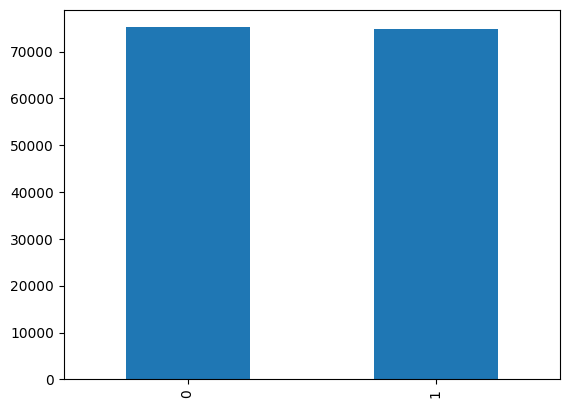

In [47]:
# 긍정, 부정 분포 그리기
train_data['label'].value_counts().plot(kind = 'bar')

In [48]:
# 정규 표현식을 이용하여 한글, 숫자, 공백을 제외하고 모두 제거 
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")

train_data[:5]

/tmp/ipykernel_50261/215865904.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [49]:
# train_data에 document 열에 빈 값을 가진 행이 있다면 Null 값으로 변경
train_data['document'].replace('', np.nan, inplace=True)

# 다시 한 번 Null 값이 존재하는지 확인
train_data.isnull().sum()

id            0
document    694
label         0
dtype: int64

In [50]:
# Null 값이 있는 행 5개만 출력
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
668,1600635,NaN,0
1559,6918082,NaN,1
1840,7095375,NaN,1
2073,384233,NaN,1
2648,423224,NaN,1


In [51]:
# NaN은 아무런 의미가 없는 데이터 이므로 제거
train_data = train_data.dropna(how = 'any')

print('전처리 후 학습용 데이터 개수 :', len(train_data))

전처리 후 학습용 데이터 개수 : 149306


In [52]:
# 테스트 데이터도 정규 표현식을 이용하여 한글, 숫자, 공백을 제외하고 모두 제거 
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")
# test_data에 document 열에 빈 값을 가진 행이 있다면 Null 값으로 변경
test_data['document'].replace('', np.nan, inplace=True)
# NaN은 아무런 의미가 없는 데이터 이므로 제거
test_data = test_data.dropna(how = 'any')

print('전처리 후 테스트용 데이터 개수 :', len(test_data))

/tmp/ipykernel_50261/2423763838.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")


전처리 후 테스트용 데이터 개수 : 49773


In [53]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [54]:
def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [55]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [56]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [57]:
len(word_to_index)

10000

In [58]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [59]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  14.105555382263951
문장길이 최대 :  84
문장길이 표준편차 :  11.586812010381065


In [60]:
# 적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  43
전체 문장의 0.954952847354357%가 maxlen 설정값 이내에 포함됩니다. 


In [61]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [62]:
print(X_train.shape)
print(X_test.shape)

(143856, 43)
(48498, 43)


In [63]:
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

In [64]:
print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(30000, 43)
(30000,)
(113856, 43)
(113856,)


### LSTM

In [65]:
vocab_size = 10000
word_vector_dim = 128

LSTM_ = keras.Sequential()
LSTM_.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_.add(keras.layers.LSTM(128))
LSTM_.add(keras.layers.Dense(1, activation='relu'))

In [66]:
LSTM_.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         1280000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [67]:
LSTM_.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [68]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [69]:
LSTM_history = LSTM_.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    callbacks=[early, check],
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1777/1779 [============================>.] - ETA: 0s - loss: 0.5112 - accuracy: 0.7874
Epoch 1: saving model to best_model.h5
1779/1779 [==============================] - 38s 21ms/step - loss: 0.5113 - accuracy: 0.7875 - val_loss: 0.4373 - val_accuracy: 0.8377
Epoch 2/10
1777/1779 [============================>.] - ETA: 0s - loss: 0.4342 - accuracy: 0.8212
Epoch 2: saving model to best_model.h5
1779/1779 [==============================] - 37s 21ms/step - loss: 0.4343 - accuracy: 0.8210 - val_loss: 0.5632 - val_accuracy: 0.6622
Epoch 3/10
1779/1779 [==============================] - ETA: 0s - loss: 0.5412 - accuracy: 0.7960
Epoch 3: saving model to best_model.h5
1779/1779 [==============================] - 37s 21ms/step - loss: 0.5412 - accuracy: 0.7960 - val_loss: 0.4510 - val_accuracy: 0.8105
Epoch 4/10
1777/1779 [============================>.] - ETA: 0s - loss: 0.4306 - accuracy: 0.8253
Epoch 4: saving model to best_model.h5
1779/1779 [==============================] - 37

In [70]:
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1516/1516 - 11s - loss: 0.5089 - accuracy: 0.8445 - 11s/epoch - 7ms/step
[0.5089258551597595, 0.8445090651512146]


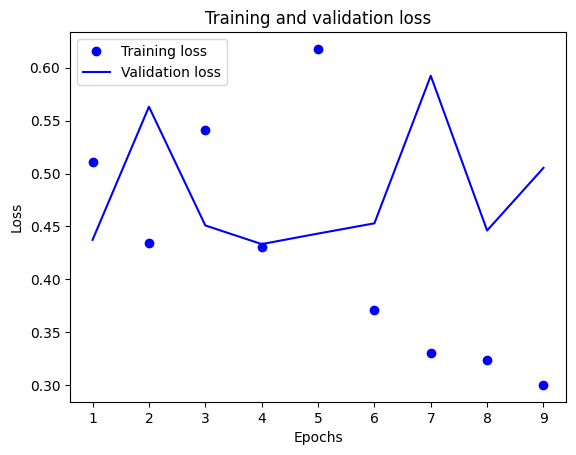

In [71]:
LSTM_history_dict = LSTM_history.history

acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [72]:
vocab_size = 10000
word_vector_dim = 128

LSTM_ = keras.Sequential()
LSTM_.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_.add(keras.layers.LSTM(128))
LSTM_.add(keras.layers.Dense(1, activation='sigmoid'))

In [73]:
LSTM_.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [74]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [75]:
LSTM_history = LSTM_.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    callbacks=[early, check],
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1777/1779 [============================>.] - ETA: 0s - loss: 0.3813 - accuracy: 0.8284
Epoch 1: saving model to best_model.h5
1779/1779 [==============================] - 37s 21ms/step - loss: 0.3813 - accuracy: 0.8284 - val_loss: 0.3391 - val_accuracy: 0.8503
Epoch 2/10
1779/1779 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.8745
Epoch 2: saving model to best_model.h5
1779/1779 [==============================] - 38s 21ms/step - loss: 0.2943 - accuracy: 0.8745 - val_loss: 0.3187 - val_accuracy: 0.8605
Epoch 3/10
1777/1779 [============================>.] - ETA: 0s - loss: 0.2501 - accuracy: 0.8958
Epoch 3: saving model to best_model.h5
1779/1779 [==============================] - 38s 22ms/step - loss: 0.2501 - accuracy: 0.8958 - val_loss: 0.3326 - val_accuracy: 0.8603
Epoch 4/10
1778/1779 [============================>.] - ETA: 0s - loss: 0.2120 - accuracy: 0.9143
Epoch 4: saving model to best_model.h5
1779/1779 [==============================] - 38

In [76]:
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1516/1516 - 11s - loss: 0.5039 - accuracy: 0.8428 - 11s/epoch - 7ms/step
[0.503932535648346, 0.8427770137786865]


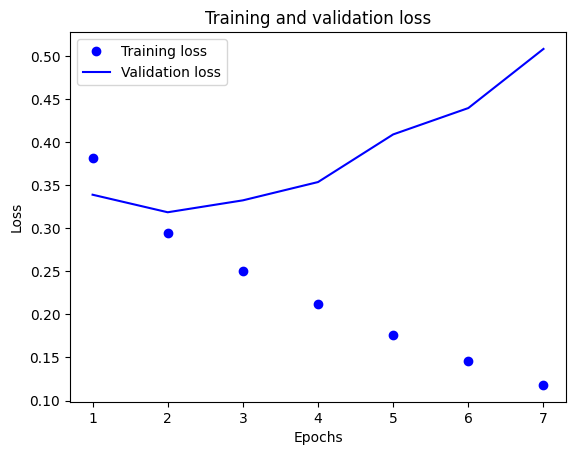

In [77]:
LSTM_history_dict = LSTM_history.history

acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 회고
아직까지 NLP에 흥미도 없고 어떤 방식으로 작동하는지 잘 모르는 상태라 본 프로젝트에 관한 
추가적인 내용은 진행하지 않았다.또한 Mecab에 설치에 대한 불친절한 설명은 본 프로젝트를 진행함에 있어 힘 빠지게 만든 주요 원인이라고 생각된다.
따라서 추후 nlp에 관심이 생긴다면 내용을 좀더 추가하여 완성할 예정이다.